# From Zero to AlexNet

This notebook is going to start with a simple neural network, and then make a series of enhancements to improve the networks's performance. By the end of this notebook, we will have constructed the AlexNet network, which was considered a major breakthrough in computer vision when published in 2012. Many of the ideas of that network are still in use today.

Alex Krizhevsky, Ilya Sutskever, and Geoffrey E. Hinton. 2017. ImageNet classification with deep convolutional neural networks. Commun. ACM 60, 6 (June 2017), 84–90. [https://doi.org/10.1145/3065386](https://doi.org/10.1145/3065386)


In [64]:
# import statements
import ipywidgets as widgets
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import datasets
from torchvision.transforms import Lambda, ToTensor

## The data set

Before we get to AlexNet, we're going to start with a simple data set, much simpler than the one used in AlexNet. The reason for using a different data set for starting is mostly performance. The data set used for AlexNet was quite large, and it's overkill for the initial models we'll build. We'll move to the full data set later, and keep tweaking from there.

In [61]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

full_training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

train_size = 50000
validation_size = 10000
train_data, validation_data = random_split(full_training_data, [train_size, val_size])

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

train_loader = DataLoader(
    dataset=train_data,
    batch_size=64,  # Number of samples per batch
    shuffle=True    # Shuffle training data
)

validation_loader = DataLoader(
    dataset=validation_data,
    batch_size=64,  # Number of samples per batch
    shuffle=True    # Shuffle training data
)

test_loader = DataLoader(
    dataset=test_data,
    batch_size=64,
    shuffle=False  # No need to shuffle test data
)

print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(validation_data)}")
print(f"Number of test samples: {len(test_data)}")

Using mps device
Number of training samples: 50000
Number of validation samples: 10000
Number of test samples: 10000


Let's take a peak at what the data looks like. Each feature is a 28x28 grayscale image. Each label is a value from 0 to 9, representing things like "Dress" and "Bag".

Text(0.5, 1.0, 'Sneaker')

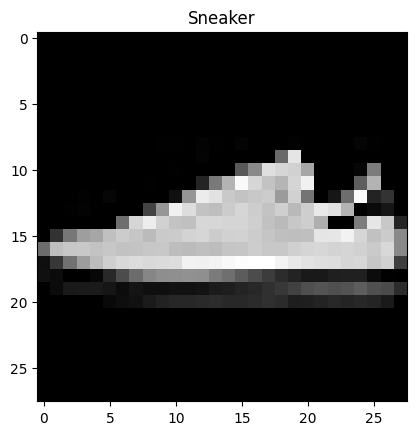

In [33]:
img, label = training_data[6]
plt.imshow(img.squeeze(), cmap="gray")
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
plt.title(labels_map[label])

## Linear Regression

The simplest neural network we can create is linear regression. Each 28x28 image gets converted to a length 784 vector $x$, with each value corresponding to a single pixel value. These are the inputs to the neural network. Each label gets converted to a length 10 vector $y$, where each value is zero except for the index corresponding to the label. That value is one. This encoding scheme is known as *one-hot encoding*. The model we then use is

$$
y = W^T x + b
$$

$W$ and $b$ are the parameter of the model that the neural net estimates. $W$ is length 784x10 vector of parameters, and $b$ is a length 10 vector of biases.

In [46]:
input_size = 28 * 28
output_size = 10

class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

linear_model = LinearRegression(input_size, output_size)
linear_model.to(device)
print(linear_model)

LinearRegression(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


## Stochastic Gradient Descent

[Stochastic Gradient Descent (SGD)](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) is an optimization technique used in machine learning to train models by minimizing a *loss function*. Instead of using the entire dataset at once, SGD updates the model's parameters (its weights) by computing gradients based on smaller subsets of data called batches. The size of each batch, known as the *batch size*, determines how many data points are used per update. An *epoch* is one complete pass through the entire dataset. The size of each step taken during the optimization process is controlled by the *learning rate*, which determines how much the parameters are adjusted in response to the gradient. To improve convergence, *momentum* is often added, which helps the optimization process move faster by maintaining some influence from the previous update, smoothing out the learning process. *Weight decay* is a regularization technique that discourages overly large weights by adding a small penalty to the loss function, which helps prevent overfitting. Together, these concepts allow SGD to efficiently learn from data and adjust the model to perform better on unseen examples.

The standard loss function for linear regression is the *mean square error (MSE)*. For a set of labels $\{y_1, \ldots, y_n\}$, and an estimated set of of labels $\{\hat{y}_1, \ldots, \hat{y}_n\}$, the MSE is

$$
MSE(\{y_1, \ldots, y_n\}, \{\hat{y}_1, \ldots, \hat{y}_n\}) = \frac{1}{nd} \sum_{i=1}^n \| y_i - \hat{y}_i \|^2.
$$

Here $n$ is the batch size, and $d$ is the number of output dimensions.


In [66]:
def train_model(model, train_loader):
    model.train()
    epochs = 40
    learning_rate = 0.01
    momentum = 0.9
    weight_decay = 0.0005

    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    # Progress bar
    my_pb = widgets.IntProgress(
        value=0,
        min=0,
        max=epochs,
        description='Progress:',
        bar_style= 'success',
        style={'bar_color': 'green'},
        orientation='horizontal'
    )
    display(my_pb)

    
    # Training loop
    for epoch in range(epochs):
        epoch_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        my_pb.value = my_pb.value + 1

train_model(linear_model, train_loader)

IntProgress(value=0, bar_style='success', description='Progress:', max=40, style=ProgressStyle(bar_color='gree…

## Softmax Regression

## Hidden Layers with ReLU

## Convolutional Layers

## Max Pooling

## Overlapping Max Pooling

## Data Augmentation

## Dropout

## Adaptive Learning Rate

## A Larger Model

## A Larger Dataset